# Lour's Pork Barrel Classifier (羅老師肉桶文本分類器)🐖
## Convolutional Neural Networks for Pork Barrel Project Classification 


author: davidycliao(David Yen-Chieh Liao)                                                                      
email: davidycliao@gmail.com                                                             
date: 9-July-2021    

-------------------------

### Stage 1: Libaries & Dependencies

In [1]:
# built-in library
# pip install -r requirements.txt
import math
import re
import collections
import zipfile
import random
from itertools import chain

# ML & Deep Learning/ NLP toolkit
import pandas as pd
import numpy as np
import jieba
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

-------------------------

### Stage 2: Data Preprocessing (Training Data: Introduction of Bills and Legislation from 6th Session to 7th Session, 2004-2012)

#### (1) Read file 

In [2]:
# read file
df = pd.read_csv('data/Pork Bill - 2021-05-20.csv', encoding='utf-8')

# combine abstract of bill and title 
df['text'] =  df['Title'] + df['Content'].fillna(df['Title'])

# drop conten without having any characters
# view na's row: df[df['text'].isnull()==True]
data = df[['text', 'pork_bill']].dropna(subset=['text'])

In [3]:
print(" Pork Legislation", data['pork_bill'].value_counts()[1],'\n', 
      "None-Pork Legislation", data['pork_bill'].value_counts()[0])

 Pork Legislation 2510 
 None-Pork Legislation 4733


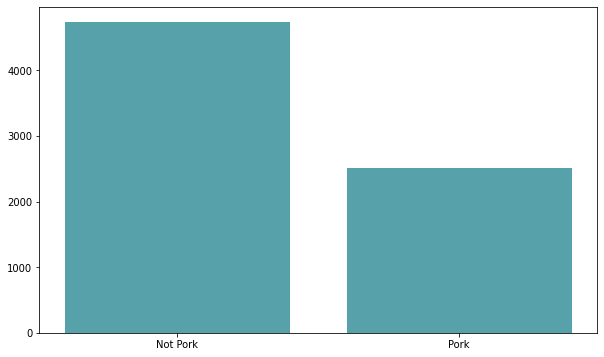

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
pork_plot = pd.DataFrame({"num":data['pork_bill'].value_counts(), "type":['Not Pork','Pork']})
plt.bar(pork_plot['type'], pork_plot['num'], color='#57A1AB')
plt.show()

#### (2) Tokenization

In [5]:
import collections
import numpy as np
import jieba
from itertools import chain


def jieba_cut(filename):
    """
    cut Chinese and remove stop words
    Reference: https://www.cnblogs.com/Luv-GEM/p/10836454.html
    Stopwords: https://www.kaggle.com/rikdifos/english-and-chinese-stopwords?select=cn_stopwords.txt
    """
    stop_list = [i.strip() for i in open('data/cn_stopwords.txt','r',encoding='utf-8')]  
    news_cut = []
    news_list = []
    for line in filename:    
        if line:
            news_cut = list(jieba.cut(''.join(line),cut_all=False,HMM=True))  
            news_list.append([word.strip() for word in news_cut if word not in stop_list and len(word.strip())>0]) 
    news_list = list(chain.from_iterable(news_list))  
    return news_list

def clearPucts(context):
    """
    remove punctuation
    ref: https://chenyuzuoo.github.io/posts/28001/
    """
    context = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "", context)
    context = re.sub("[【】╮╯▽╰╭★→「」]+","", context)
    context = re.sub("！，❤。～《》：（）【】「」？”“；：、","",context)
    context = re.sub("\s","",context)
    return context

def seg_char(sent):
    """
    cut Chinese and remove stop words
    ref: https://blog.csdn.net/renyuanfang/article/details/86487367
    """
    # split
    pattern_char_1 = re.compile(r'([\W])')
    parts = pattern_char_1.split(sent)
    parts = [p for p in parts if len(p.strip())>0]
    # cut sentence
    pattern = re.compile(r'([\u4e00-\u9fa5])')
    chars = pattern.split(sent)
    chars = [w for w in chars if len(w.strip())>0]
    chars = ' '.join(chars)
    return chars

In [6]:
data_clean = [seg_char(text) for text in [clearPucts(text) for text in data.text]]

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    data_clean, target_vocab_size=2**18)

data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

#### (3) Padding

In [7]:
MAX_LEN = max([len(sentence) for sentence in data_clean])
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value=0,
                                                            padding="post",
                                                            maxlen=MAX_LEN)




In [8]:
data_inputs.shape

(7243, 785)

#### (4) Spliting Training / Testing Set

In [9]:
data_labels = data.pork_bill.values

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    data_inputs, data_labels, test_size=0.33, random_state=42)

print("Shape of X Train:", train_inputs.shape, '\n'
      "Shape of X Test :", test_inputs.shape,'\n'
      "Shape of Y Trian:", train_labels.shape , '\n'
      "Shape of Y Test :", test_labels.shape )

Shape of X Train: (4852, 785) 
Shape of X Test : (2391, 785) 
Shape of Y Trian: (4852,) 
Shape of Y Test : (2391,)


In [11]:
unique_train_labels, counts_train_labels = np.unique(train_labels, return_counts=True)

print(' Num of Train Set:' , train_inputs.shape[0], '\n'
      ,'Not Pork vs Pork:', dict(zip(unique_train_labels, counts_train_labels)))

 Num of Train Set: 4852 
 Not Pork vs Pork: {0: 3167, 1: 1685}


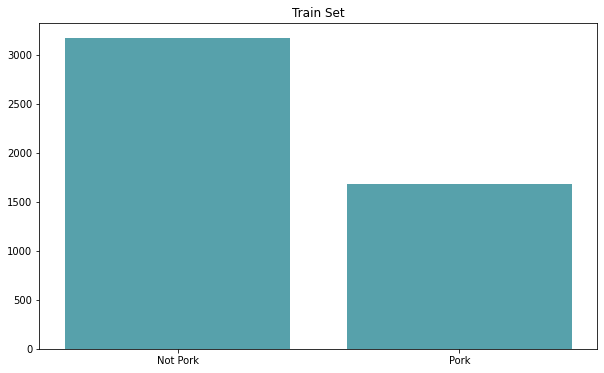

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
train_plot = pd.DataFrame({"num":[dict(zip(unique_train_labels, counts_train_labels))[0],
                                  dict(zip(unique_train_labels, counts_train_labels))[1]], 
                           "type":['Not Pork','Pork']})
plt.bar(train_plot['type'], train_plot['num'], color='#57A1AB')
plt.title('Train Set')
#plt.show()
plt.savefig('images/train_plot.png')

In [13]:
unique_test_labels, counts_test_labels = np.unique(test_labels, return_counts=True)

print(' Num of Test Set:' , test_inputs.shape[0], '\n'
      ,'Not Pork vs Pork:', dict(zip(unique_test_labels, counts_test_labels)))

 Num of Test Set: 2391 
 Not Pork vs Pork: {0: 1566, 1: 825}


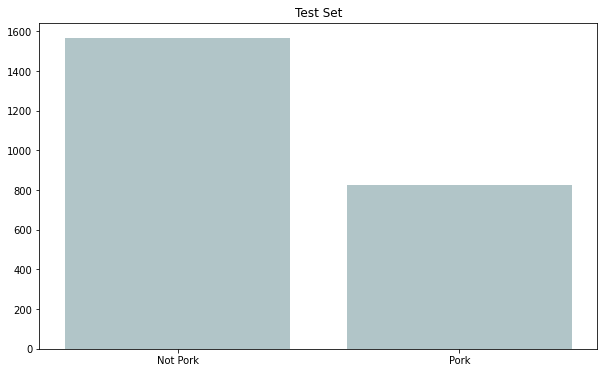

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
test_plot = pd.DataFrame({"num":[dict(zip(unique_test_labels, counts_test_labels))[0],
                                 dict(zip(unique_test_labels, counts_test_labels))[1]], 
                          "type":['Not Pork','Pork']})
plt.bar(test_plot['type'], test_plot['num'], color='#B1C5C8')
plt.title('Test Set')
#plt.show()
plt.savefig('images/test_plot.png')

-------------------------


### Stage 3: Model and Building

#### (1) Using the Subclassing API to Build Dynamic Model

In [15]:
class DCNN(tf.keras.Model):
    def __init__(self,
                 vocab_size,
                 emb_dim=128,
                 nb_filters=100,
                 # units: Positive integer, dimensionality of the output space.
                 FFN_units=512,
                 nb_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="PorkCNN"):
        super(DCNN, self).__init__(name=name)
        self.embedding = layers.Embedding(vocab_size, emb_dim)
        self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, strides = 1, padding="valid", activation="relu")
        self.bigram2 = layers.Conv1D(filters=nb_filters, kernel_size=2, strides = 2, padding="valid", activation="relu")
        self.trigram = layers.Conv1D(filters=nb_filters,kernel_size=3,strides = 1, padding="valid",activation="relu")
        self.trigram2 = layers.Conv1D(filters=nb_filters,kernel_size=3,strides = 2, padding="valid",activation="relu")
        self.fourgram = layers.Conv1D(filters=nb_filters,kernel_size=4,strides = 2, padding="valid",activation="relu")
        self.fivegram = layers.Conv1D(filters=nb_filters,kernel_size=5,strides = 2, padding="valid",activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        self.dense_1 = layers.Dense(units=FFN_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.last_dense = layers.Dense(units=1, activation="sigmoid")    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_1_1 = self.bigram2(x)
        x_1_1 = self.pool(x_1_1)        
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_2_1 = self.trigram2(x)
        x_2_1 = self.pool(x_2_1)     
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)
        x_4 = self.fourgram(x)
        x_4 = self.pool(x_4) 
        x_5 = self.fivegram(x)
        x_5 = self.pool(x_5)      
        merged = tf.concat([x_1,x_1_1, x_2,x_2_1, x_3, x_4, x_5], axis=-1) 
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)        
        return output

In [16]:
VOCAB_SIZE = tokenizer.vocab_size  #tokenizer.vocab_size  # 5000 tokenizer.vocab_size
EMB_DIM = 200
NB_FILTERS = 100
FFN_UNITS = 256
NB_CLASSES = 2 #len(set(train_labels))
DROPOUT_RATE = 0.25
BATCH_SIZE = 230
NB_EPOCHS = 80

Dcnn = DCNN(vocab_size=VOCAB_SIZE,
            emb_dim=EMB_DIM,
            nb_filters=NB_FILTERS,
            FFN_units=FFN_UNITS,
            nb_classes=NB_CLASSES,
            dropout_rate=DROPOUT_RATE)

2022-02-22 22:38:49.726343: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### (2) Compile and Summary of the Model

In [17]:
Dcnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
Dcnn.build(input_shape = (train_inputs.shape[1], EMB_DIM
                         )) # (train_inputs.shape[1] , EMB_DIM)  (785 , EMB_DIM)
Dcnn.summary()

Model: "PorkCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  586600    
                                                                 
 conv1d (Conv1D)             multiple                  40100     
                                                                 
 conv1d_1 (Conv1D)           multiple                  40100     
                                                                 
 conv1d_2 (Conv1D)           multiple                  60100     
                                                                 
 conv1d_3 (Conv1D)           multiple                  60100     
                                                                 
 conv1d_4 (Conv1D)           multiple                  80100     
                                                                 
 conv1d_5 (Conv1D)           multiple                  1001

#### (3) Check Point Path

In [18]:
checkpoint_path = "checkpoint_recode/ckpt_manager"

ckpt = tf.train.Checkpoint(Dcnn=Dcnn)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Checkpoint Located!!")

-------------------------

### Stage 4: Train the Model

In [19]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [20]:
Dcnn.fit(train_inputs, train_labels,
         validation_data=(test_inputs, test_labels),
         batch_size=BATCH_SIZE,
         epochs=NB_EPOCHS,
         callbacks=[early_stop])
ckpt_manager.save()

Epoch 1/80
22/22 [==============================] - 40s 2s/step - loss: 0.6059 - accuracy: 0.6494 - val_loss: 0.5103 - val_accuracy: 0.7808
Epoch 2/80
22/22 [==============================] - 42s 2s/step - loss: 0.3754 - accuracy: 0.8528 - val_loss: 0.2575 - val_accuracy: 0.8950
Epoch 3/80
22/22 [==============================] - 47s 2s/step - loss: 0.1758 - accuracy: 0.9334 - val_loss: 0.1780 - val_accuracy: 0.9318
Epoch 4/80
22/22 [==============================] - 50s 2s/step - loss: 0.0890 - accuracy: 0.9683 - val_loss: 0.1537 - val_accuracy: 0.9452
Epoch 5/80
22/22 [==============================] - 53s 2s/step - loss: 0.0518 - accuracy: 0.9835 - val_loss: 0.1697 - val_accuracy: 0.9444
Epoch 6/80
22/22 [==============================] - 46s 2s/step - loss: 0.0610 - accuracy: 0.9819 - val_loss: 0.1987 - val_accuracy: 0.9335
Epoch 7/80
22/22 [==============================] - 47s 2s/step - loss: 0.0559 - accuracy: 0.9860 - val_loss: 0.1735 - val_accuracy: 0.9452
Epoch 8/80
22/22 [==

'checkpoint_recode/ckpt_manager/ckpt-1'

-------------------------

### Stage 5: Evaluation

In [21]:
losses = pd.DataFrame(Dcnn.history.history)
losses

,loss,accuracy,val_loss,val_accuracy
0,0.605947,0.649423,0.510334,0.780845
1,0.375364,0.852844,0.257516,0.895023
2,0.175829,0.933430,0.178023,0.931828
3,0.088962,0.968261,0.153718,0.945211
4,0.051790,0.983512,0.169675,0.944375
5,0.061041,0.981863,0.198732,0.933501
6,0.055922,0.985985,0.173460,0.945211
7,0.041117,0.988871,0.181670,0.943956
8,0.041197,0.986810,0.185922,0.940611


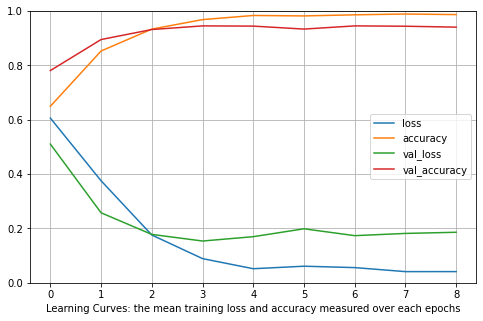

In [22]:
losses.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.xlabel("Learning Curves: the mean training loss and accuracy measured over each epochs")
plt.savefig('images/learning_curves3.png')
plt.show()

In [23]:
from sklearn.metrics import classification_report,confusion_matrix
evaluation_model = Dcnn.evaluate(test_inputs, test_labels, batch_size=BATCH_SIZE)
print(evaluation_model)

11/11 [==============================] - 5s 421ms/step - loss: 0.1859 - accuracy: 0.9406
[0.18592208623886108, 0.9406106472015381]


In [24]:
# pd.DataFrame(confusion_matrix(test_labels,predictions))
predictions = Dcnn.predict(test_inputs)
predictions = np.where(predictions >0.8 , 1, 0)
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1566
           1       0.93      0.89      0.91       825

    accuracy                           0.94      2391
   macro avg       0.94      0.93      0.94      2391
weighted avg       0.94      0.94      0.94      2391



In [25]:
t = pd.DataFrame(confusion_matrix(test_labels,predictions), 
             columns=['Predictions: Not Pork(0)','Predictions:Pork(1)'])
t.index = ['Acutal: Not Pork(0)', 'Acutal: Pork (1)']
t

,Predictions: Not Pork(0),Predictions:Pork(1)
Acutal: Not Pork(0),1514,52
Acutal: Pork (1),87,738


-------------------------

### Stage 6: Try the Model with New Data and Export an End-to-end Model


#### (1) Test New Dataset from 2000 samples from Legislative Questions from 6th Session 

In [26]:
def as_num(x):
    """
    keep 10 decimals
    """
    y = '{:.15f}'.format(x) 
    return y

In [27]:
import pandas as pd
import random

# test the trined model using new text from 200 samples from Leislative Questions
LQ6 = pd.read_csv('data/LQ_6th.csv')

# drop '0': legislor  never have proposed any legisaltive questions. 
LQ6 = LQ6[LQ6['title'].isin(['0'])== False]

# select text with number of charecters within EMB_DIM; len(sub_set) = 11162
# sample_df = LQ6.loc[[len(char_num) for char_num in LQ6.title if len(char_num) < MAX_LEN], ['legislator','title', 'topic', 'category', 'keywords', 'ques_type']].reset_index(drop=True)
random.seed(42)
sample_df = LQ6.iloc[random.sample(range(len(LQ6)), 2000)][['legislator', 'title', 'topic', 'category', 'keywords', 'ques_type']]
sub_set = [seg_char(text) for text in [clearPucts(text) for text in sample_df.title]]


##### Top 10 of 2000 Samples

In [28]:
top = pd.DataFrame(
    {'legislator': sample_df.legislator,
     'Pork Value(Constituency Interest)':[as_num(Dcnn(np.array([tokenizer.encode(line)]), training=True).numpy()[0][0]) for line in sub_set],
     'Legislative Questions ': sample_df.title,
     'Topic': sample_df.topic,
     'Key Word':sample_df.keywords}).sort_values(by=['Pork Value(Constituency Interest)'], ascending = False)

In [29]:
top.head(10)

,legislator,Pork Value(Constituency Interest),Legislative Questions,Topic,Key Word
9892,陳啟昱,0.998417615890503,鑑於現行《所得稅法》第十七條規定特別扣除額教育支出部分，僅以納稅義務人之子女就讀大專院校為限...,所得稅 ; 教育費用 ; 扣除額,所得稅法 ; 特別扣除額 ; 教育支出
3999,林正峰,0.997364819049835,針對政府準備修法推動「二代健保」，健保保費採取「年度所得總額」為計算基礎，而非採用扣除免稅額...,國民 ; 健康保險 ; 保險費,二代健保 ; 年度所得總額
1761,彭添富,0.996990680694580,針對「辦理九十四年原住民中低收入戶家庭租屋補助計畫」專案補助計畫，特向行政院提出質詢。,原住民族生活,原住民中低收入戶 ; 租屋補助
35,丁守中,0.994604468345642,針就民眾陳情指出，目前政府對身心障礙者提供之生活津貼，依身心障礙程度等級分為1000元至50...,身心障礙者福利,身心障礙者生活津貼
1706,彭添富,0.993997812271118,針對「觀音鄉保生社區風貌營造規劃設計」專案補助計畫，特向行政院提出質詢。,社區計畫 ; 政府補助,保生社區
188,丁守中,0.992515802383423,針就「國軍退除役官兵就養安置辦法」第七條第一項第五款規定：「全家人口所有之土地及房屋公告現值...,退除役官兵 ; 榮民生活輔導,國軍退除役官兵就養安置辦法
619,吳成典,0.990735411643982,鑑於居家安全及消防常識已逐漸受到民眾的重視，請中央寬列消防機關人事費用，補助金、馬兩縣規劃合...,住宅安全 ; 消防設施,居家安全 ; 消防常識
1641,彭添富,0.988783240318298,針對「豪雨成災，農作物損失補償」問題，特向行政院提出質詢。,農業補助,豪雨 ; 農作物
8340,蔡煌瑯(離職),0.986971139907837,「2005南投花卉嘉年華」活動爭取中央經費補助案由，特向行政院提出質詢。,農業推廣 ; 政府補助,南投花卉嘉年華 ; 中央經費
9527,鄭朝明,0.986645400524139,針對我國生育率逐年下降，嚴重影響人口結構發展。民眾不願多生育子女，主因在於負擔費用過重，政府...,出生率 ; 人口政策,生育率 ; 人口 ; 人口老化


##### Last 10 Rows of 2000 Samples

In [30]:
top.tail(10)

,legislator,Pork Value(Constituency Interest),Legislative Questions,Topic,Key Word
10120,陳朝龍,0.000003376766927,針對英國政府宣稱台灣出口至該國禽鳥，檢驗出感染禽流感H5N1病毒死亡。由於我國迄今並未發現有...,傳染病防治 ; 走私,英國政府 ; 台灣禽鳥 ; 禽流感 ; 相思鳥 ; 走私
6347,王幸男,0.000003163653446,針對本院交通委員會在台中市長夫人邵曉鈴女士車禍事件之後，以超高的效率通過了「道路交通管理處罰...,交通規則,道路交通管理處罰條例 ; 安全帶
2866,李鎮楠,0.000002799774620,針對國內近來頻傳黑心食品充斥市面，引起消費者恐慌，提出相關質疑。黑心事件層出不窮，餵豬澱粉回...,食品管理,黑心食品 ; 食品認證
2439,李俊毅,0.000002592328201,針對近來國務機要費與首長特別費因相關規範未臻明確，遭質疑該筆金額等同於首長薪水或私房錢，且有...,國家元首 ; 行政首長 ; 統一發票,國務機要費 ; 首長特別費
2018,曹來旺,0.000002244937150,針對政府宣示廢除死刑多年，雖然死刑的法律仍在，但判處死刑的案例減少，即使判了死刑，也常拖著不...,死刑,死刑 ; 人權
6532,王幸男,0.000002108804438,針對陳總統日昨重申，有信心一定能夠在二○○八年卸任總統之前，為台灣催生一部合身、合時、合用的...,憲法修正,新憲法 ; 修改憲法
8264,蔡其昌,0.000001428694077,針對近年來詐騙集團盛行，傳送大量簡訊詐財，雖內政部警政署自八月一日起，特別提供簡訊特碼「09...,詐欺 ; 電話,詐騙 ; 來電顯號
7514,紀國棟,0.000001150604248,鑒於台灣極力發展觀光倍增之際，竟一再傳出中國觀光客來台糾紛頻傳，爰要求觀光局為下列改進：一、...,旅遊業 ; 觀光,中國觀光客 ; 旅遊糾紛
982,周守訓,0.000001047020760,針對日前媒體報導陳水扁總統宣示，十二月二十五日耶誕節是重要的宗教節慶，更是我國的行憲紀念日，...,宗教 ; 假日,耶誕節 ; 行憲紀念日 ; 宗教自由 ; 政教分離
6636,王幸男,0.000000255493234,針對「莊嚴肅穆」的行憲紀念日，在威權時代「今天應懸掛國旗」，不過，在愈來愈多人的真實生活中，...,紀念活動 ; 憲政運作,聖誕節 ; 行憲紀念日 ; 制憲權


#### (2) Export an End-to-end Model


In [31]:
from tensorflow.keras.models import load_model

In [32]:
# Get model (Sequential, Functional Model, or Model subclass)
Dcnn.save('lour_pork_model')

2022-02-22 22:47:42.366664: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: lour_pork_model/assets


INFO:tensorflow:Assets written to: lour_pork_model/assets


In [ ]:
from tensorflow import keras
model = keras.models.load_model('lour_pork_model')